# **VERSUSVIRUS - Team 306 - Real Time Bed Monitoring**
---
GENERATION OF SYNTHETIC DATA FOR MODEL TRAINING PURPOSES.

**Summary of sampling approach:**


The goal of this project is to have a real time view on how many beds (ICU & non ICU) are available across Switzerland. To augment such monitoring capability, predictive modeling techniques that forecast how long a patient will remain hospitalized will be applied. Such approach allows for a more accurate resource planning of hospital beds and distribution of patients across Swiss hospitals.
The following approach was taken to generate the data:

1. Use a data synthesizer to produce ~10k hospital patients (source: https://github.com/theodi/synthetic-data-tutorial)

2. Adjust synthetic data to Switzerland and current time frame (March/April 2020)

3. Map data to number of beds available in Swiss hospitals (source: https://docs.google.com/spreadsheets/d/1uSisBqRAgp-cNlYPePOUF4YX_idp0JaeZEVyY3MbaJk/edit#gid=0)

4. Sample data according to volume of ICU beds available in Swiss hospitals

5. Sample admission type : ICU invasive, ICU non-invasive, Non-ICU (source: https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html)

6. Augment data with patient information about symptoms & preconditions and sample according to frequency of occurrence (source: https://jamanetwork.com/journals/jama/fullarticle/2761044)

7. Engineer duration of stay based on admission type & death occurrence (https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html , https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm#T1_down)

*Please note that not all assumptions have been available prior generation of the data and some might deviate from the underlying literature. Conditional occurance of medical preconditions and gender biases were not included in this first version.*



In [0]:
from google.colab import drive

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/VersusVirus_Hackathon/synthetic-data-tutorial-master")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **RUN THE SYNTHETIC DATA GENERATOR**

Please download the following source: https://github.com/theodi/synthetic-data-tutorial

In [0]:
!ls

data		 plots			  requirements.txt
DataSynthesizer  README.md		  Synthetic_data.ipynb
LICENSE		 requirements_freeze.txt  tutorial


In [0]:
#!curl -o "./data/London postcodes.csv" https://www.doogal.co.uk/UKPostcodesCSV.ashx?region=E12000007

In [0]:
#!python tutorial/generate.py # execute the script that generates the fake data -> for now everything is UK talored, I think it's not worth the effort to make this CH specific for now

## **Pre-Process the UK mock data**

In [0]:
import pandas as pd
hospital_ae_df = pd.read_csv('./data/hospital_ae_data.csv')
hospital_ae_df = hospital_ae_df.drop('Health Service ID', 1)
postcodes_df = pd.read_csv('./data/London postcodes.csv')
hospital_ae_df = pd.merge(
    hospital_ae_df,
    postcodes_df[['Postcode', 'Lower layer super output area']],
    on='Postcode'
)
hospital_ae_df = hospital_ae_df.drop('Postcode', 1)
hospital_ae_df = pd.merge(
    hospital_ae_df,
    postcodes_df[['Lower layer super output area', 'Index of Multiple Deprivation']].drop_duplicates(),
    on='Lower layer super output area'
)

hospital_ae_df['Arrival Time'] = pd.to_datetime(hospital_ae_df['Arrival Time'], format='%Y-%m-%d %H:%M:%S.%f') 
### make timestamps more recent
hospital_ae_df['Arrival Time'] = hospital_ae_df['Arrival Time'] + pd.DateOffset(months=11, days=5)

_, bins = pd.qcut(
    postcodes_df['Index of Multiple Deprivation'],
    10,
    retbins=True,
    labels=False
)

# add +1 to get deciles from 1 to 10 (not 0 to 9)
hospital_ae_df['Index of Multiple Deprivation Decile'] = pd.cut(
    hospital_ae_df['Index of Multiple Deprivation'],
    bins=bins,
    labels=False,
    include_lowest=True) + 1

hospital_ae_df = hospital_ae_df.drop('Index of Multiple Deprivation', 1)
hospital_ae_df = hospital_ae_df.drop('Lower layer super output area', 1)

arrival_times = pd.to_datetime(hospital_ae_df['Arrival Time'])
hospital_ae_df['Arrival Date'] = arrival_times.dt.strftime('%Y-%m-%d')
hospital_ae_df['Arrival Hour'] = arrival_times.dt.hour
#hospital_ae_df = hospital_ae_df.drop('Arrival Time', 1)

hospital_ae_df['Arrival hour range'] = pd.cut(
    hospital_ae_df['Arrival Hour'],
    bins=[0, 4, 8, 12, 16, 20, 24],
    labels=['00-03', '04-07', '08-11', '12-15', '16-19', '20-23'],
    include_lowest=True
)
hospital_ae_df = hospital_ae_df.drop('Arrival Hour', 1)

hospital_ae_df = hospital_ae_df[hospital_ae_df['Gender'].isin(['Male', 'Female'])]

hospital_ae_df['Age bracket'] = pd.cut(
    hospital_ae_df['Age'],
    bins=[0, 18, 25, 45, 65, 85, 150],
    labels=['0-17', '18-24', '25-44', '45-64', '65-84', '85-'],
    include_lowest=True
)
#hospital_ae_df = hospital_ae_df.drop('Age', 1)

In [0]:
#hospital_ae_df.to_csv("./data/hospital_ae_data_preprocess", index=False)

In [0]:
hospital_ae_df["Arrival Date"].value_counts().plot(kind='barh')

## **Adjust data to Switzerland**

In [0]:
import numpy as np
icu_ch = pd.read_csv('./data/ICU switzerland.csv')
icu_ch['Gewicht'] = icu_ch['zertifizierte  Betten'] / sum(icu_ch['zertifizierte  Betten'])
icu_ch = icu_ch.drop_duplicates()
icu_ch = icu_ch.sort_values('Gewicht', ascending=False)
icu_ch['Unique - Hospital'] = icu_ch['Spital'] + '-' + icu_ch['Station']

fill_list = np.array(icu_ch['Unique - Hospital'])
weight_list = np.array(icu_ch['Gewicht'])

hospital_ae_df['Unique - Hospital'] = np.NaN
hospital_ae_df['Unique - Hospital'] = hospital_ae_df['Unique - Hospital'].fillna(pd.Series(np.random.choice(fill_list, p=weight_list ,size=len(hospital_ae_df))))
hospital_ae_df = hospital_ae_df.dropna().drop_duplicates()

df = hospital_ae_df.merge(icu_ch, how='left',on='Unique - Hospital')
df.drop(columns='Index of Multiple Deprivation Decile', inplace=True)


## **Feature Engineering** 

Literature: https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm#T1_down


## Admission Type

Change the assumptions in admission_dist 
Assumptions taken from: https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html

In [0]:
admission_list = np.array(['ICU - Invasive', 'ICU - Non Invasive', 'Non-ICU'])
admission_dist = np.array([0.03,0.27, 0.7])

In [0]:
df['Admission Type'] = np.NaN
df['Admission Type'] = df['Admission Type'].fillna(pd.Series(np.random.choice(admission_list, p=admission_dist ,size=len(df))))

In [0]:
round(df['Admission Type'].value_counts() / len(df),2)

Non-ICU               0.70
ICU - Non Invasive    0.27
ICU - Invasive        0.03
Name: Admission Type, dtype: float64

## Signs, Symptoms & Preconditions

Assumptions taken from: https://jamanetwork.com/journals/jama/fullarticle/2761044

In [0]:
import pandas as pd
dist_df = pd.read_excel('../Profiling_of_Covid19_Patients.xlsx')
dist_df = round(dist_df, 2)

In [0]:
dist_df['PCT TOTAL TOTAL'] = dist_df.Total / 138
dist_df['ICU - PCT TOTAL'] = dist_df['ICU Total'] / dist_df['Total'] * dist_df['PCT TOTAL TOTAL']
dist_df['ICU - Invasive PCT TOTAL'] = dist_df['ICU - Invasive'] / dist_df['Total'] * dist_df['PCT TOTAL TOTAL']
dist_df['ICU - NON Invasive PCT TOTAL'] = dist_df['ICU - Non Invasive'] / dist_df['Total'] * dist_df['PCT TOTAL TOTAL']
dist_df['Non-ICU Pct TOTAL'] = dist_df['Non-ICU'] / dist_df['Total'] * dist_df['PCT TOTAL TOTAL']
dist_df = round(dist_df, 2)


In [0]:
dist_df

,Variable,Total,ICU Total,ICU - Invasive,ICU - Non Invasive,Non-ICU,ICU - PCT TOTAL,ICU - Invasive PCT TOTAL,ICU - NON Invasive PCT TOTAL,Non-ICU Pct TOTAL,PCT TOTAL TOTAL
0,Female,63,14,13,1,49,0.10,0.09,0.01,0.36,0.46
1,Male,75,22,20,2,43,0.16,0.14,0.01,0.31,0.54
2,Hypertension,43,21,19,2,22,0.15,0.14,0.01,0.16,0.31
3,Cardiovascular Disease,20,8,7,1,6,0.06,0.05,0.01,0.04,0.14
4,Diabetes,14,8,7,1,6,0.06,0.05,0.01,0.04,0.10
5,Malignacy,10,4,4,0,6,0.03,0.03,0.00,0.04,0.07
6,Cerebrovascular disease,7,6,5,1,1,0.04,0.04,0.01,0.01,0.05
7,COPD,4,3,3,0,1,0.02,0.02,0.00,0.01,0.03
8,Chronoc kidney disease,4,2,2,0,2,0.01,0.01,0.00,0.01,0.03
9,Chronic liver disease,4,0,0,0,4,0.00,0.00,0.00,0.03,0.03


In [0]:
new_vars = list(dist_df['Variable'].values)
new_vars = new_vars[2:]


In [0]:
df = pd.concat([df, pd.DataFrame(columns= new_vars)]) #add new variables to dataframe

In [0]:
j = 'ICU - Invasive PCT TOTAL'
k = 'ICU - Invasive'
for i in new_vars:
  dummies = np.array([1,0])
  proba_ = np.array([dist_df[(dist_df['Variable'] == i)][j].values[0], 1-dist_df[(dist_df['Variable'] == i)][j].values[0]])
  df.loc[df['Admission Type'] == k, i] = pd.Series(np.random.choice(dummies, p=proba_ ,size=len(df)))


j = 'ICU - NON Invasive PCT TOTAL'
k = 'ICU - Non Invasive'
for i in new_vars:
  dummies = np.array([1,0])
  proba_ = np.array([dist_df[(dist_df['Variable'] == i)][j].values[0], 1-dist_df[(dist_df['Variable'] == i)][j].values[0]])
  df.loc[df['Admission Type'] == k, i] = pd.Series(np.random.choice(dummies, p=proba_ ,size=len(df)))


j = 'Non-ICU Pct TOTAL'
k = 'Non-ICU'
for i in new_vars:
  dummies = np.array([1,0])
  proba_ = np.array([dist_df[(dist_df['Variable'] == i)][j].values[0], 1-dist_df[(dist_df['Variable'] == i)][j].values[0]])
  df.loc[df['Admission Type'] == k, i] = pd.Series()

In [0]:
k = 'Non-ICU'

for i in new_vars[-3:]:
  if i == 'Heart Rate (median)':
    mu, sigma = 86, 3 # mean and standard deviation
    df.loc[df['Admission Type'] == k, i] = np.round(pd.Series(np.random.normal(mu, sigma, len(df))),2)
  if i == 'Respiratory Rate (median)':
    mu, sigma = 20, 1.2 # I made the standard deviation up assuming it's quasi normally distributed
    df.loc[df['Admission Type'] == k, i] = np.round(pd.Series(np.random.normal(mu, sigma, len(df))), 2)
  if i == 'Mean arterial pressure  (median)':
    mu, sigma = 90, 1.2 # I made the standard deviation up assuming it's quasi normally distributed
    df.loc[df['Admission Type'] == k, i] = np.round(pd.Series(np.random.normal(mu, sigma, len(df))), 2)

k = 'ICU - Non Invasive'

for i in new_vars[-3:]:
  if i == 'Heart Rate (median)':
    mu, sigma = 89, 3 # mean and standard deviation
    df.loc[df['Admission Type'] == k, i] = np.round(pd.Series(np.random.normal(mu, sigma, len(df))),2)
  if i == 'Respiratory Rate (median)':
    mu, sigma = 20, 1.2 # I made the standard deviation up assuming it's quasi normally distributed
    df.loc[df['Admission Type'] == k, i] = np.round(pd.Series(np.random.normal(mu, sigma, len(df))), 2)
  if i == 'Mean arterial pressure  (median)':
    mu, sigma = 91, 1.2 # I made the standard deviation up assuming it's quasi normally distributed
    df.loc[df['Admission Type'] == k, i] = np.round(pd.Series(np.random.normal(mu, sigma, len(df))), 2)

k = 'ICU - Invasive'

for i in new_vars[-3:]:
  if i == 'Heart Rate (median)':
    mu, sigma = 90, 3 # mean and standard deviation
    df.loc[df['Admission Type'] == k, i] = np.round(pd.Series(np.random.normal(mu, sigma, len(df))),2)
  if i == 'Respiratory Rate (median)':
    mu, sigma = 20, 1.2 # I made the standard deviation up assuming it's quasi normally distributed
    df.loc[df['Admission Type'] == k, i] = np.round(pd.Series(np.random.normal(mu, sigma, len(df))), 2)
  if i == 'Mean arterial pressure  (median)':
    mu, sigma = 91, 1.2 # I made the standard deviation up assuming it's quasi normally distributed
    df.loc[df['Admission Type'] == k, i] = np.round(pd.Series(np.random.normal(mu, sigma, len(df))), 2)



In [0]:
df.to_csv('../FEATURE_SET_WITHOUT_TARGET.csv')

Number of Symptoms are predictor

In [0]:
pre_conditons = ['Hypertension', 'Cardiovascular Disease', 'Diabetes', 'Malignacy', 'Cerebrovascular disease', 'COPD', 'Chronoc kidney disease', 'Chronic liver disease', 'HIV infection']
symptoms = ['Fever', 'Fatigue', 'Dry cough ', 'Anorexia', 'Myalgia', 'Dyspnea', 'Expectoration', 'Pharyngalgia', 'Diarrhea', 'Nausea', 'Dizziness', 'Headache', 'Vomiting ', 'Abdominal Pain']

In [0]:
df['# of pre_conditions'] = np.sum(df[pre_conditons], axis=1)
df['# of symptoms'] = np.sum(df[symptoms], axis=1)

Factor in death occurence for the duration of stay

In [0]:
df['Death'] = np.NaN

i = 'Death'

k = 'ICU - Invasive'
dummies = np.array([1,0])
proba_ = np.array([0.55, 0.45])
df.loc[df['Admission Type'] == k, i] = pd.Series(np.random.choice(dummies, p=proba_ ,size=len(df)))

k = 'ICU - Non Invasive'
proba_ = np.array([0.2, 0.8])
df.loc[df['Admission Type'] == k, i] = pd.Series(np.random.choice(dummies, p=proba_ ,size=len(df)))

k = 'Non-ICU'
proba_ = np.array([0.05, 0.95])
df.loc[df['Admission Type'] == k, i] = pd.Series(np.random.choice(dummies, p=proba_ ,size=len(df)))


## Target Variable

**ASSUMPTIONS THAT HAVE BEEN USED FOR SAMPLING THE DATA VARY WITHIN LITERATURE AND MIGHT NOT BE CORRECT**

source: [LINK 1](https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html) ,[LINK 2](https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm#T1_down)



In [0]:
df['DUATION OF STAY'] = np.NaN
k = 'DUATION OF STAY'

for i in np.unique(df['Admission Type']):
  if (i == 'ICU - Invasive'):
    df.loc[(df['Admission Type'] == i) & ((df['Death'] == 1)), k] = np.round(pd.Series(np.random.normal(7, 1, len(df))),0)
    df.loc[(df['Admission Type'] == i) & ((df['Death'] == 0)), k] = np.round(pd.Series(np.random.normal(17, 1, len(df))),0)
  if i == 'ICU - Non Invasive':
    df.loc[(df['Admission Type'] == i) & ((df['Death'] == 1)), k] = np.round(pd.Series(np.random.normal(7, 1, len(df))),0) #assuming patient has same progression as Invasive
    df.loc[(df['Admission Type'] == i) & ((df['Death'] == 0)), k] = np.round(pd.Series(np.random.normal(9, 1, len(df))),0)
  if i == 'Non-ICU':
    df.loc[(df['Admission Type'] == i) & ((df['Death'] == 1)), k] = np.round(pd.Series(np.random.normal(14, 1, len(df))),0) #assuming patient takes a longer time until he gets worse and patient dies
    df.loc[(df['Admission Type'] == i) & ((df['Death'] == 0)), k] = np.round(pd.Series(np.random.normal(5, 1, len(df))),0) # assuming they get discharged fast



In [0]:
df.drop(columns = 'Hospital', inplace=True)
df.drop(columns = 'Treatment', inplace=True)
df.drop(columns = 'Time in A&E (mins)', inplace=True)

In [0]:
df['Discharge Time'] = np.NaN

for i in range(0, len(df)):
  df['Discharge Time'][i] = df['Arrival Time'][i] +  pd.DateOffset(df['DUATION OF STAY'][i])


In [0]:
df.head(3)

,Age,Arrival Time,Gender,Arrival Date,Arrival hour range,Age bracket,Unique - Hospital,Spital,Latitude,Longitude,Station,PLZ,Ort,Full Address,zertifizierte Betten,Titel,Leitung Vorname,Leitung Name,Leitung Pflege,Anza hl,Status SGI Zertifizierung,Zertifikat von,Zertifikat bis,Gewicht,Admission Type,Hypertension,Cardiovascular Disease,Diabetes,Malignacy,Cerebrovascular disease,COPD,Chronoc kidney disease,Chronic liver disease,HIV infection,Fever,Fatigue,Dry cough,Anorexia,Myalgia,Dyspnea,Expectoration,Pharyngalgia,Diarrhea,Nausea,Dizziness,Headache,Vomiting,Abdominal Pain,Heart Rate (median),Respiratory Rate (median),Mean arterial pressure (median),# of pre_conditions,# of symptoms,Death,DUATION OF STAY,Discharge Time
0,49.0,2020-03-12 18:32:31,Female,2020-03-12,16-19,45-64,Kantonsspital Bruderholz-Inst. für Anästhesie ...,Kantonsspital Bruderholz,47.527935,7.581290,Inst. für Anästhesie und Intensivmedizin,4101.0,Bruderholz,Kantonsspital Bruderholz 4101 Bruderholz,9.0,Dr. med.,Peter,Gerecke,Stephan Ness,1.0,anerkannt,NaN,NaN,0.009288,Non-ICU,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,0,0,0,87.1,18.75,90.17,0.0,7.0,0.0,5.0,2020-03-17 18:32:31
1,22.0,2020-03-08 11:36:48,Female,2020-03-08,08-11,18-24,Regionalspital Emmental Burgdorf-Interdiszipli...,Regionalspital Emmental Burgdorf,47.048411,7.620813,Interdisziplinäre Intensivstation,3400.0,Burgdorf,Regionalspital Emmental Burgdorf 3400 Burgdorf,6.0,Dr. med.,Brigitte,Ulrich,Hans-Christoph Mewes,1.0,zertifiziert,28.03.18,27.03.23,0.006192,Non-ICU,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,88.79,20.54,89.72,0.0,3.0,0.0,5.0,2020-03-13 11:36:48
2,51.0,2020-03-11 04:34:57,Female,2020-03-11,00-03,45-64,Kantonsspital St. Gallen (KSSG)-Chirur. Intens...,Kantonsspital St. Gallen (KSSG),47.430653,9.387419,Chirur. Intensivstation CH IPS,9007.0,St. Gallen,Kantonsspital St. Gallen (KSSG) 9007 St. Gallen,24.0,Prof. Dr. med.,Miodrag,Filipovic,Holger Braun,1.0,anerkannt,NaN,NaN,0.024768,Non-ICU,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,82.34,20.52,90.68,1.0,3.0,0.0,4.0,2020-03-15 04:34:57


In [0]:
df.to_excel('../TRAINING_DURATION_OF_STAY.xlsx')

## DISTRIBUTION OF DURATION OF STAY

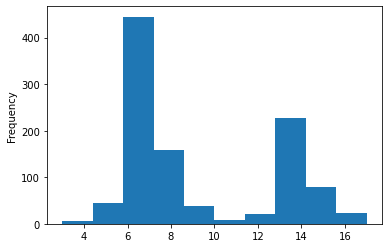

In [0]:
## Sanity check -> we see two clusters, the patients that die earlier in ICU and those who die with a longer progression and were previosuly non-ICU 
df[df.Death == 1]['DUATION OF STAY'].plot(kind='hist')

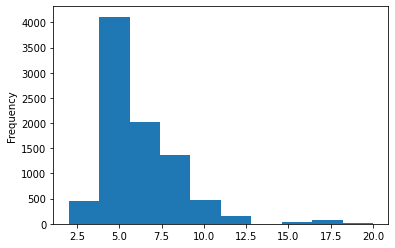

In [0]:
## RECOVERED PATIENTS
df[df.Death == 0]['DUATION OF STAY'].plot(kind='hist')